# iNERF test

In [1]:
import torch
import torch.nn as nn
from models.vanilla_nerf.model import NeRF
from PIL import Image
from pathlib import  Path as P
import json
import torchvision.transforms as transforms
import numpy as np
from datasets.ray_utils import get_ray_directions
import matplotlib.pyplot as plt
from models.vanilla_nerf.model_nerfseg import  get_rays_torch
from models.vanilla_nerf.helper import img2mse
from pytorch3d.transforms import quaternion_to_matrix
import torch.nn.functional as F

/home/dj/anaconda3/envs/ao/lib/python3.8/site-packages/torchmetrics/utilities/imports.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _PYTHON_LOWER_3_8 = LooseVersion(_PYTHON_VERSION) < LooseVersion("3.8")
/home/dj/anaconda3/envs/ao/lib/python3.8/site-packages/torchmetrics/utilities/imports.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _PYTHON_LOWER_3_8 = LooseVersion(_PYTHON_VERSION) < LooseVersion("3.8")
/home/dj/anaconda3/envs/ao/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/dj/anaconda3/envs/ao/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
/home/dj/anacond

## Helper functions

In [2]:
def load_json(json_fname):
    with open(json_fname, 'r') as json_file:
        data_dict = json.load(json_file)
    return data_dict

def remove_model_prefix(input_dict):
    """
    Remove the "model." prefix from all key names in a dictionary.

    Args:
        input_dict (dict): The input dictionary.

    Returns:
        dict: A new dictionary with the "model." prefix removed from key names.
    """
    output_dict = {}
    for key, value in input_dict.items():
        # Check if the key starts with "model."
        if key.startswith("model."):
            # Remove the "model." prefix and add to the new dictionary
            new_key = key[len("model."):]
            output_dict[new_key] = value
        else:
            # If the key doesn't start with "model.", add it as is
            output_dict[key] = value
    return output_dict

def load_model_with_check(model, state_dict_dict):
    """
    Load a PyTorch model's state_dict from a dictionary and report missing
    and unexpected keys.

    Args:
        model (torch.nn.Module): The model to which the state_dict should be loaded.
        state_dict_dict (dict): The state_dict dictionary.

    Returns:
        model (torch.nn.Module): The model with the loaded state_dict.
        missing_keys (list): List of keys that were in the state_dict but not in the model.
        unexpected_keys (list): List of keys that were in the model but not in the state_dict.
    """
    # Load the state_dict
    state_dict = state_dict_dict

    # Load the model's state_dict and track missing and unexpected keys
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)

    # Report missing and unexpected keys
    if missing_keys:
        print("Missing keys in the model's state_dict:")
        for key in missing_keys:
            print(key)
    if unexpected_keys:
        print("Unexpected keys found in the model's state_dict:")
        for key in unexpected_keys:
            print(key)

    return model, missing_keys, unexpected_keys

def select_fg(value, seg):
    # Squeeze the seg tensor to remove the singleton dimension
    seg = seg.squeeze(dim=1)
    
    # Create a mask for the selected segments
    mask = (seg > 0)

    # Apply the mask to the value tensor to select the desired elements
    selected_value = value[mask]

    return selected_value

def select_element(value, seg, part_num=0):
    # Squeeze the seg tensor to remove the singleton dimension
    seg = seg.squeeze(dim=1)
    
    # Create a mask for the selected segments
    mask = (seg == part_num)

    # Apply the mask to the value tensor to select the desired elements
    selected_value = value[mask]

    return selected_value

def overlay_images(image_A, image_B, transparency):
    """
    Overlay two images with adjustable transparency.

    Args:
    - image_A (PIL Image): The base image.
    - image_B (PIL Image): The overlay image.
    - transparency (float): The transparency level (0.0 to 1.0, where 0.0 is fully transparent, and 1.0 is fully opaque).

    Returns:
    - PIL Image: The overlayed image.
    """
    # Ensure that both images have the same size
    if image_A.size != image_B.size:
        raise ValueError("Both input images must have the same size")

    # Convert the transparency value to an alpha value (0 to 255)
    alpha = int(255 * (1 - transparency))

    # Create copies of the images to avoid modifying the originals
    base_image = image_A.copy()
    overlay_image = image_B.copy()

    # Apply the transparency to the overlay image
    overlay_image.putalpha(alpha)

    # Paste the overlay image onto the base image
    base_image.paste(overlay_image, (0, 0), overlay_image)

    return base_image

def render_img(model, directions, c2w, chunk_size=4096):
    randomized = False
    white_bkgd = True
    far=6
    near=2
    chunk_size = 1024 * 3
    # get rays_o, rays_d, view_dir 
    rays_o, viewdirs, rays_d = get_rays_torch(directions, c2w[:3, :], output_view_dirs=True)
    chunk_len = rays_o.shape[0] // chunk_size + 1
    chunk_idxs = torch.arange(0, chunk_len) * chunk_size
    chunk_idxs[-1] = rays_o.shape[0]
    ret_list = []
    with torch.no_grad():
        for i in range(len(chunk_idxs) - 1):
            mini_batch = {}
            begin, end = chunk_idxs[i], chunk_idxs[i+1]
            mini_batch['rays_o'] = rays_o[begin: end]
            mini_batch['rays_d'] = rays_d[begin: end]
            mini_batch['viewdirs'] = viewdirs[begin: end]
            mini_ret = model.forward(mini_batch, randomized, white_bkgd, near, far)

            ret_list += [mini_ret[1][0].detach().cpu()]
    ret_rgb = torch.cat(ret_list, dim=0)
    return ret_rgb

def save_images_as_gif(imgs, interval, save_path):
    """
    Save a list of numpy arrays as a GIF file.

    Args:
    - imgs (list of numpy arrays): List of images to be saved as frames in the GIF.
    - interval (int): Time interval between frames in milliseconds.
    - save_path (str): Filepath where the GIF should be saved.

    Returns:
    - None
    """
    # Ensure the save_path ends with '.gif'
    if not save_path.endswith('.gif'):
        save_path += '.gif'

    # Convert numpy arrays to PIL images
    pil_imgs = [Image.fromarray(np.uint8(img*255)) for img in imgs]

    # Save the images as a GIF
    pil_imgs[0].save(save_path, save_all=True, append_images=pil_imgs[1:], duration=interval, loop=0)
    return pil_imgs

## Load data for optimization

In [3]:
# root_path = P("./data/laptop_art_same_pose/train/idx_1/")
root_path = P("./data/laptop_10211/test/")
device = 'cuda'
transform_meta = load_json(str(root_path / 'transforms.json'))
frame_id = 'r_2'
pose_np = np.array(transform_meta['frames']['r_3'])

rgb_pil = Image.open(str(root_path/'rgb'/(frame_id + '.png')))
rgb = transforms.ToTensor()(rgb_pil).to(device)
rgb = rgb.view(4, -1).permute(1, 0) # (H*W, 4) RGBA
rgb = rgb[:, :3]*rgb[:, -1:] + (1-rgb[:, -1:]) # blend A to RGB

seg_pil = Image.open(str(root_path/'seg'/(frame_id + '.png')))
pose = torch.Tensor(pose_np).to(device)
seg_np = np.array(seg_pil)
print('input shape: ', seg_np.shape)
seg = torch.Tensor(seg_np).to(device).view([1, -1]).permute(1, 0)
seg = seg.type(torch.LongTensor)
seg = seg - 1 # starts with 2
seg[seg<0] = 0
focal = transform_meta['focal']
w, h = 640, 480
directions = get_ray_directions(h, w, focal).view([-1, 3])

input shape:  (480, 640)


/home/dj/anaconda3/envs/ao/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
seg.max()

tensor(2)

## NeRF model setup

In [5]:
# load ckpt state_dict
ckpt_file = "results/laptop/nerf_laptop/last.ckpt"
ckpt_dict_model = torch.load(ckpt_file)['state_dict']
ckpt_dict = remove_model_prefix(ckpt_dict_model)
# initialize model and load pre-trained weights
model = NeRF()
model, _, _ = load_model_with_check(model, ckpt_dict)
model = model.to(device)

## Add view transform variable

In [6]:
class ViewTransform(nn.Module):
    def __init__(self, mode='Q'):
        super().__init__()
        if mode == 'Q':
            self.initialize_param = torch.Tensor([
                1, 0, 0, 0, 0, 0, 0
            ]) # [Q, T]
        else:
            self.initialize_param = torch.Tensor([
                [1, 0, 0, 0], 
                [0, 1, 0, 0],
                [0, 0, 1, 0]
            ]).view([-1])
        self.mode = mode
        self.weight = nn.Parameter(self.initialize_param, requires_grad = True)

    def forward(self, input):
        """
        input: 4x4 c2w matrix
        """
        constant = torch.Tensor([
            [0, 0, 0, 1]
        ]).to(dtype=self.weight.dtype, device=self.weight.device)
        if self.mode == 'Q':
            Q = self.weight[:4]
            # print(Q)
            T = self.weight[4:].view([3, 1])
            norm_Q = Q / torch.linalg.norm(Q.clone(), ord=2)
            rot = R_from_quaternions(norm_Q)
            m34 = torch.cat((rot, T), dim=1)
            weight = torch.cat((m34, constant), dim=0)
        else:
            weight = torch.cat((self.weight.view([3, 4]), constant), dim=0)
            # print(weight)
        new_view_point = torch.matmul(weight, input)
        return new_view_point
    
    def reset(self):
        initialize_param = torch.Tensor([
            [1, 0, 0, 0], 
            [0, 1, 0, 0],
            [0, 0, 1, 0]
        ]).view([-1])
        device = self.weight.device
        self.weight = nn.Parameter(initialize_param, requires_grad = True).to(device)


def R_from_quaternions(quaternions: torch.tensor):
    quaternions = F.normalize(quaternions, p=2., dim=0)

    r, i, j, k = torch.unbind(quaternions, -1)
    two_s = 2.0 / (quaternions * quaternions).sum(-1)

    o = torch.stack(
        (
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
        ),
        -1,
    )
    return o.reshape(quaternions.shape[:-1] + (3, 3)).to(quaternions)


view_deform = ViewTransform().to(device)

## configure optimizer

In [7]:
optimizer = torch.optim.Adam(view_deform.parameters(), lr=0.005, weight_decay=1e-4)

## Forward function

In [8]:


directions = directions.to(device)
# gather directions and rgbs based on part label from seg (select value where seg == part_num)
# help me write the function select_element(value, seg, part_num=0), value in shape [N, k], seg in shape [N, 1], return [n, k]
# selected_dirs = select_element(directions, seg, part_num=2).to(device)
# selected_rgbs = select_element(rgb, seg, part_num=2).to(device)

# selected_dirs = select_fg(directions, seg).to(device)
# selected_rgbs = select_fg(rgb, seg).to(device)

# use mini batches


In [9]:
from tqdm import tqdm
optimize_step = 300
result = []

# view_deform.reset()
# loop over the following steps until converge or optimize for a certain number of step
for step in range(optimize_step):

    optimizer.zero_grad()

    # random_indx = torch.randint(0, selected_dirs.shape[0], [4096])
    # random_dirs = selected_dirs[random_indx]
    # random_rgbs = selected_rgbs[random_indx]

    random_indx = torch.randint(0, directions.shape[0], [4096])
    random_dirs = directions[random_indx]
    random_rgbs = rgb[random_indx]

    # go through view_deform module to get new view point matrix
    new_pose = view_deform(pose)
    # generate rays with new_view_point and selected directions
    rays_o, viewdirs, rays_d = get_rays_torch(random_dirs, new_pose[:3, :], output_view_dirs=True)
    # gather input_dict for NeRF
    input_dict = {
        'rays_o': rays_o,
        'rays_d': rays_d,
        'viewdirs': viewdirs
    }
    # gather rendered resutls from NeRF coarse and fine
    rendered_results = model(input_dict, False, True, 2, 6)
    coarse_rgb = rendered_results[0][0]
    fine_rgb = rendered_results[1][0]
    # calculate and print loss
    loss0 = img2mse(coarse_rgb, random_rgbs)
    loss1 = img2mse(fine_rgb, random_rgbs)
    loss = loss0 + loss1
    # update variable
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print('loss at step %d: %.4f' % (step, loss.item()))
        result += [new_pose]
    pass
torch.cuda.empty_cache()

loss at step 0: 0.0319
loss at step 10: 0.0297
loss at step 20: 0.0354
loss at step 30: 0.0337
loss at step 40: 0.0286
loss at step 50: 0.0280
loss at step 60: 0.0301
loss at step 70: 0.0275
loss at step 80: 0.0278
loss at step 90: 0.0255
loss at step 100: 0.0203
loss at step 110: 0.0225
loss at step 120: 0.0078
loss at step 130: 0.0113
loss at step 140: 0.0075
loss at step 150: 0.0018
loss at step 160: 0.0031
loss at step 170: 0.0028
loss at step 180: 0.0017
loss at step 190: 0.0024
loss at step 200: 0.0032
loss at step 210: 0.0018
loss at step 220: 0.0019
loss at step 230: 0.0036
loss at step 240: 0.0018
loss at step 250: 0.0016
loss at step 260: 0.0028
loss at step 270: 0.0022
loss at step 280: 0.0026
loss at step 290: 0.0020


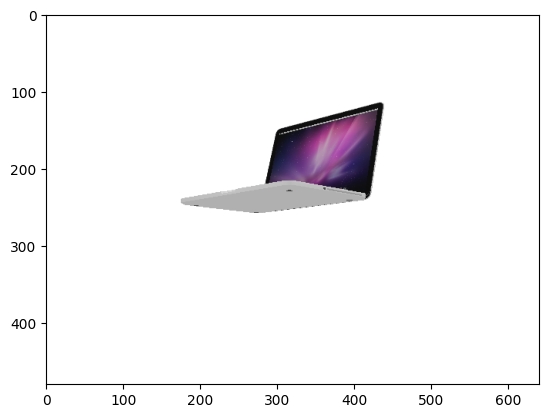

In [10]:
target_img = rgb.view([h, w, 3]).cpu().numpy()
plt.imshow(target_img)

In [11]:
result_img = []

for p in tqdm(result):
    ret_rgb = render_img(model, directions, p, chunk_size=4096*8)
    img = ret_rgb.view([h, w, 3]).cpu().numpy()
    result_img  += [img]

100%|██████████| 30/30 [03:17<00:00,  6.58s/it]


In [12]:
target_pil = Image.fromarray(np.uint8(target_img*255))

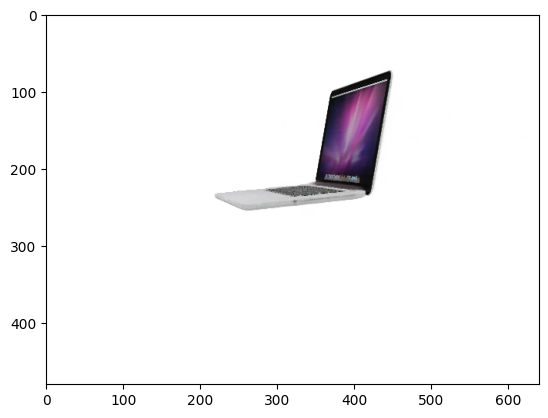

In [13]:
plt.imshow(result_img[2])

In [14]:
pil_imgs = save_images_as_gif(result_img, 1000, './result.gif')

In [15]:
overlay_list = [overlay_images(target_pil, img, 0.5) for img in pil_imgs]
overlay_list[0].save("./result_overlay.gif", save_all=True, append_images=overlay_list[1:], duration=1000, loop=0)